# Importamos librerías - Creamos el dataframe de pericias

In [202]:
import pandas as pd
import numpy as np
from pprint import pprint

df = pd.read_csv('pericias_medicas.csv', sep=',',  encoding='utf-8')
#convierte en string los datos de la columna text
df1 = df['text'].apply(str)


## Limpieza de texto

In [203]:
# Limpieza de texto
# Primera etapa de la limpieza de texto
import re, string, unicodedata
'''
Se hace la eliminacion de texto entre corchetes, acentos, signos de puntuacion (excepto . y :), palabras con numeros.
Se eliminan los espacios de sobra
Se eliminan \r, \t, \v, \f, \a
'''
def limpiarTexto1(txt: str, bert=False, nums=False) -> str:
    """
    Elimina caracteres no deseados
    Params:
        **txt**:texto a ser limpiado de caracteres no desaeados
    """
    if nums:
        txt = re.sub(r'\d+', ' ', txt)
    if not bert:
        txt = txt.translate(str.maketrans(
            'áéíóúýàèìòùÁÉÍÓÚÀÈÌÒÙÝ', 'aeiouyaeiouAEIOUAEIOUY'))

    '''
    Eliminamos caracteres especiales: tabulador orizontal(\t), tabulador vertical(\v), 
    retorno de carro(\r), avance de pagina(\f), 
    caracter de retroceso: Marca el límite de una palabra(\b), 
    '''
    txt = txt.replace('\r', ' ').replace("\v", ' ').replace(
        "\t", ' ').replace("\f", ' ').replace("\a", ' ').replace("\b", ' ')
    txt = re.sub(' +', ' ', txt)
    txt = txt.strip()
    return txt
df1 = df1.apply(str)
df1 = df1.apply(limpiarTexto1)

In [204]:
# Segunda fase de limpieza
# Se eliminan todos los elementos que meten ruido al texto y que no fueron eliminados en la fase de limpieza 1.
import re

def limpiarTexto2(text):
    text = re.sub('^ ',' ',text)
    text = re.sub('\n +\n','\n',text)
    text = re.sub(' +\n\n','\n',text)
    text = re.sub('\n\n+','\n',text)
    text = re.sub(' \n','\n',text)
    text = re.sub('\d\n','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('\u200b\n','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('\d+-\d+','',text)
    text = re.sub('\x0c','',text)
    text = re.sub('[nN]º|[nN][. ]º','',text)
    text = re.sub('[º<>/]','',text)
    text = re.sub('\d{3,100}','',text)
    text = re.sub('[a-zA-z-.]+@[a-zA-Z]+.com','',text)
    return text

df1 = df1.apply(limpiarTexto2)

In [249]:
# Tercera fase de limpieza
# Eliminamos las lineas que no son de utilidad para el analisis o que van a afectar los resultados del mismo.
# Ejemplo de linea eliminada: las lineas que comienzan con "Se encuentra contestada en....."
import re

def limpiarTexto3(text):
    text = re.sub('[a-z1-9.]+[).-] [s|S]e encuentra contestad[a|o] .+[. \n]','',text)
    text = re.sub('[0-9]+[. ]+[yY]a fue contestado.+[.\n]','',text)
    text = re.sub('[fF]oja [1-9].+\n', '', text)
    text = re.sub('[pP]regunta[ 0-9]+[)].+\n|[rR]espuesta[ 0-9]+[)].+\n','',text)#elimina oraciones comenzadas en preguta/respuesta.
    text = re.sub('V[. ]+S.', '', text)
    #text = re.sub('[IV]+.[A-Z]{1,3}[\n.]', '', text)
    text = re.sub('[I][.][P][.]','',text)
    text = re.sub('[I][.][T][.]','',text)
    text = re.sub('[I][.][A][.]','',text)
    text = re.sub('[I][.][L][.]','',text)
    text = re.sub('[I][.][B][.]','',text)
    text = re.sub('[I][.][N][.]','',text)
    text = re.sub('[I][.][V][.]','',text)
    text = re.sub('[V][.][M][.]','',text)
    text = re.sub('[V][.][A][.]','',text)

    return text

dfLimpio = df1.apply(limpiarTexto3)
dfLimpio = dfLimpio.apply(limpiarTexto2)
#pprint(dfLimpio[0])

# Búsqueda de títulos

In [206]:
# Búsqueda de títulos
# Se crea un nuevo dataframe de títulos según distintos criterios

# busca titulos que comienzan con numeros romanos
def buscarTitulosRomanos(text):
    # Expresiones regulares para encontrar los numeros romanos
    tituloNroRomano =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)+[-.)][\w\s-]+[:\n]')
    tituloNroRomano5 =re.compile(r'V[-.)]+[\w\s-]+[:\n]')
    titulosRomanosEncontrados = []

    for m in tituloNroRomano.finditer(text):
        titulosRomanosEncontrados.append(m.group())
    for m in tituloNroRomano5.finditer(text):
        titulosRomanosEncontrados.append(m.group())
        
    return titulosRomanosEncontrados

# titulosConNroRomano: lista que guarda los titulos que comienzan con numeros romanos   
titulosConNroRomano=[]
for expediente in dfLimpio:
    titulosConNroRomano.append(buscarTitulosRomanos(expediente))

In [207]:
# Busca títulos que comienzan con números latinos
def buscarTitulosLatinos(text):
    # Expresiún regular para encontrar tútulos que comienzan con números
    tituloNroLatino =re.compile(r'[1-9][-.)][\w\s-]+[:\n]')
    titulosLatinosEncontrados = []

    for m in tituloNroLatino.finditer(text):
        titulosLatinosEncontrados.append(m.group())

    return titulosLatinosEncontrados

# titulosConNroLatino: lista que guarda los tútulos que comienzan con números latinos
titulosConNroLatino=[]
for expediente in dfLimpio:
    titulosConNroLatino.append(buscarTitulosLatinos(expediente))

In [277]:
# Busca títulos en mayusculas
def buscarTitulosMayusculas(text):
    # Expresiín regular para encontrar títulos en mayusculas.
    tituloMayusculas =re.compile(r'(I{1,3}|IV|V|VI{1,3}|IX|X)[-.)][A-Z -]+[:.\n]') #[1-9]|
    titulosMayusculasEncontrados = []

    for m in tituloMayusculas.finditer(text):
        titulosMayusculasEncontrados.append(m.group())

    return titulosMayusculasEncontrados
# titulosMAyuscula: lista que guarda los títulos en mayusculas
titulosMayusculas=[]
for expediente in dfLimpio:
    titulosMayusculas.append(buscarTitulosMayusculas(expediente))

dfTitulosMayusculasConStops = pd.DataFrame(titulosMayusculas)


In [252]:
# Ultima limpieza de titulos
def limpiarTitulosHTML(text):
    text = re.sub('[n]','',text)
    text = re.sub('[\\\]',' ',text)
    return text
titulosMayusculas = limpiarTitulosHTML(str(titulosMayusculas))

## Eliminación de stopwords. Nueva limpieza

In [257]:
import nltk
import re

stops = nltk.corpus.stopwords.words('spanish')

# elimino stopwords
def remove_stops(texto: str) -> str:
    """
    Función que elimina stopwords
    Params:
        **texto**:texto a ser limpiado de stopwords

    """
    texto = [
        i for i in texto.split() if i not in stops
    ]
    return texto

def limpiarTitulos(text):
    text = text.lower()
    text = re.sub(r'\n','',text)
    text = re.sub(r'[a-z]\.[a-z]\.','',text)
    text = re.sub(r'(i{2,3}|iv|vi{1,3}|ix)','',text)
    text = re.sub(r'\W',' ',text)    
    text = re.sub(r'\d+','',text)
    text = re.sub(r' [a-z] ','',text)
    
    
    return text

# elimino stopwords y hago una última limpieza
titulosMayusculasStop = limpiarTitulos(str(titulosMayusculas))
titulosMayusculasStop = remove_stops(str(titulosMayusculasStop))
titulosConNroLatinoStop = limpiarTitulos(str(titulosConNroLatino))
titulosConNroLatinoStop = remove_stops(str(titulosConNroLatinoStop))
titulosConNroRomanoStop = limpiarTitulos(str(titulosConNroRomano))
titulosConNroRomanoStop = remove_stops(str(titulosConNroRomanoStop))

# FASE DE ANALISIS

## Creación de dataframes de títulos

In [258]:
# crear un df de títulos.
import pandas as pd

dfTitulosRomanos = pd.DataFrame(titulosConNroRomanoStop)
dfTitulosLatinos= pd.DataFrame(titulosConNroLatinoStop)
dfTitulosMayusculas= pd.DataFrame(titulosMayusculasStop)


# dfTitulos = pd.DataFrame()
# dfTitulos['latinos'] = titulosConNroLatinoStop
# dfTitulos['romanos'] = pd.DataFrame(titulosConNroRomanoStop)
# dfTitulos['mayusculas'] = pd.DataFrame(titulosMayusculasStop)

In [33]:
# from pandas import ExcelWriter

# writer = ExcelWriter('E:/Descargas-E/titulos_en_mayusculas.xlsx')
# dfTitulosMayusculasConStops.to_excel(writer, 'Hoja de datos', index=False)
# writer.save()

## Contadores

In [259]:
# Titulos totales del dataframe original
def contarPalabras(text):
    totalPalabras = 0
    for expediente in text:
        p = expediente.split()
        totalPalabras+=(len(p))
    return totalPalabras

# Total de palabras en el datrafame origina.
palabrasTotalesDf = contarPalabras(df1)

# Contadores de títulos
# Total de titulos por tipo de busqueda
contTitulosLatino = len(titulosConNroLatinoStop)
contTitulosRomanos = len(titulosConNroRomanoStop)
contTitulosmayusculas = len(titulosMayusculasStop)
totalPalabrasTitulos = contTitulosLatino + contTitulosRomanos + contTitulosmayusculas

# Mostrar por pantalla la cantidad de palabras por tituto, cantidad de palabras totales
print(f'''Palabras en titulos ROMANOS:           {contTitulosRomanos}
Palabras en titulos LATINOS:           {contTitulosLatino}
Palabras en titulos con MAYUSCULAS:    {contTitulosmayusculas}

TOTAL DE PALABRAS ENCONTRADAS EN TITULOS:   {totalPalabrasTitulos}

TOTAL DE PALABRAS DEL DATAFRAME ORIGINAL:   {palabrasTotalesDf}
''')

Palabras en titulos ROMANOS:           33938
Palabras en titulos LATINOS:           175264
Palabras en titulos con MAYUSCULAS:    10392

TOTAL DE PALABRAS ENCONTRADAS EN TITULOS:   219594

TOTAL DE PALABRAS DEL DATAFRAME ORIGINAL:   8693476



### Dataframe de frecuencias

In [260]:
# Obtengo la frecuencia relativa de las palabras de los titulos
frecuenciaTitulosRomanos = dfTitulosRomanos.value_counts()
frecuenciaTitulosLatinos = dfTitulosLatinos.value_counts()
frecuenciaTitulosMayuscula = dfTitulosMayusculas.value_counts()

# Crea un dataframe de frecuencias
dfFrecuencias = pd.DataFrame()
dfFrecuencias['latinos'] = frecuenciaTitulosLatinos
dfFrecuencias['romanos'] = pd.DataFrame(frecuenciaTitulosRomanos)
dfFrecuencias['mayuscula'] = pd.DataFrame(frecuenciaTitulosMayuscula)


In [261]:
# mostrar por pantalla la frecuencia de titulos
print(f'''FRECUENCIA DE PALABRAS
TITULOS EN MAYUSCULA
{frecuenciaTitulosMayuscula[1:10]}''')

FRECUENCIA DE PALABRAS
TITULOS EN MAYUSCULA
puntos             535
pericia            511
conclusiones       483
petitorio          440
legales            436
antecedentes       436
consideraciones    379
legal              308
interes            279
dtype: int64


# GRAFICOS

<module 'matplotlib.pyplot' from 'c:\\Users\\gasto\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

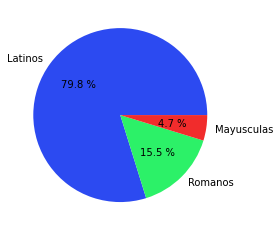

In [262]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

# Creacion de grafico de torta de la cantidad de titulos encontrados segun el tipo de busqueda
cantTitulos = [contTitulosLatino, contTitulosRomanos, contTitulosmayusculas]
nombreTitulos = ['Latinos', 'Romanos', 'Mayusculas']
colores = ['#2C4AF1','#2CF168','#F12C2C']

plt.pie(cantTitulos, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores)
plt

<module 'matplotlib.pyplot' from 'c:\\Users\\gasto\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

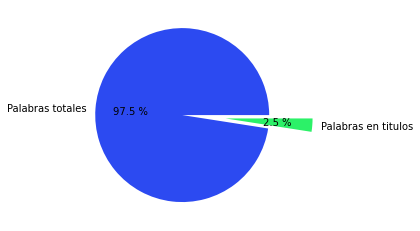

In [263]:
# Creo un grafico de torta
import matplotlib.pyplot as plt

# Creacion de grafico de torta de la cantidad de titulos encontrados sobre la cantidad de palabras en total de dataframe
cantPalabras = [palabrasTotalesDf, totalPalabrasTitulos]
nombreTitulos = ['Palabras totales', 'Palabras en titulos']
colores = ['#2C4AF1','#2CF168']
desfase=(0,0.5)

plt.pie(cantPalabras, labels=nombreTitulos, autopct= '%0.1f %%', colors=colores, explode=desfase) #, explode=desfase
plt

## NUBE DE PALABRAS

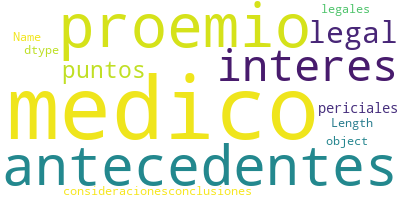

In [270]:
# Import the wordcloud library
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(dfTitulosMayusculas.apply(str)))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

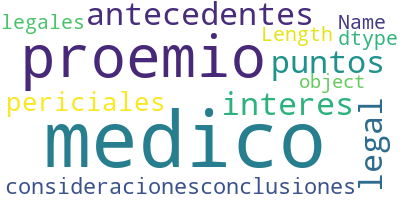

In [265]:
# elimino stopwords de la nube de palabras.
import nltk

stops = nltk.corpus.stopwords.words('spanish')

# agregar palabra a la lista
#stops.append('algo')


# Import the wordcloud library
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(dfTitulosMayusculas.apply(str)))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', stopwords=stops) #, stopwords=stops

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

# PRUEBAS

In [271]:
# DIVIDIR EN ORACIONES:
from nltk import sent_tokenize
# dividir en oraciones
sentences = sent_tokenize(dfLimpio[0])
#print(sentences[])

In [272]:
pprint(sentences.index('-EXAMENES COMPLEMENTARIOS: Psicodiagnostico (los test estan adjuntados\n'
 'en autos)\n'
 'IV-CONSIDERACIONES MEDICO-LEGALES:\n'
 'Comenta el Sr Boiero que mientras se dirigia al trabajo, corre para no\n'
 'perder el tren pisando mal con su pie izquierdo por lo cual sufrio un '
 'esguince del\n'
 ' tobillo izquierdo.'))

59


In [273]:
pprint(sentences[59])
print('\n')
pprint(f'Esta oración tiene: {len(sentences)} palabras')

('-EXAMENES COMPLEMENTARIOS: Psicodiagnostico (los test estan adjuntados\n'
 'en autos)\n'
 'IV-CONSIDERACIONES MEDICO-LEGALES:\n'
 'Comenta el Sr Boiero que mientras se dirigia al trabajo, corre para no\n'
 'perder el tren pisando mal con su pie izquierdo por lo cual sufrio un '
 'esguince del\n'
 ' tobillo izquierdo.')


'Esta oración tiene: 143 palabras'


## Creamos un vectorizador para ver las frecuencias de palabras por documento

In [44]:
# Importamos librerias necesarias.
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import nltk

stops = nltk.corpus.stopwords.words('spanish')

vectorizer = TfidfVectorizer(stop_words=set(stops))
X = vectorizer.fit_transform(dfLimpio)


In [45]:
true_k = 4
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

In [ ]:
for i in range(true_k): 
    print(f'Cluster %d:' % i, ), 
    for ind in order_centroids[i, :10]: 
        print(' %s' % terms[ind])   


print('\n') 
print('Predicción***************************') 
X = vectorizer.transform(['consideraciones medico legales']) 
predicted = model.predict(X)
print(predicted)

# Muestro en documento HTML

In [274]:
# Creamos un dataframe para colocar el salto de linea en formato HTML
dfLimpioHTML = dfLimpio.apply(str)
def limpiarTextoHTML(text):
    text = text.strip().replace('\n','<br>')
    return text

dfLimpioHTML = dfLimpioHTML.apply(limpiarTextoHTML)


In [284]:
colors = {
    'procedimientos': '#cd5c5c',
    'cuerpos': '#99ccff',
    'afecciones': '#ffa500'
}

body = f'''
        <p>
        {dfLimpioHTML[0]}
        </p>
        <br>
        '''
for titulo in titulosMayusculas[0]:
    body = body.replace(titulo,f'<span style="background-color: #99ccff">{titulo}</span>')
with open('titulos.html','w', encoding="utf-8") as f:
    f.write(body)